# Helmholtz 1D - AutoAMG on a Fixed Domain Size

## Goal
Given the Helhmholtz operator $A = \Delta + k^2 I$ on a fixed domain with periodic boundary conditions, find **test functions** $x$ of unit $l_2$ norm with small $\|A x\|$; i.e., near-null-space components, and a multilevel hierarchy that is able to solve $A u = f$ fast.

In general, $k=k(x)$ varies over the domain. In thesse experiments, $k$ is constant, but we do not assume this knowledge.

## Discretization
We use the 5-point finite difference $A^h = [-1, 16, -30 + 12 (kh)^2, 16, -1]$. In this experiment we use a fixed periodic domain with $n=96$ points and a small $kh=0.5$.

In [604]:
import logging
import numpy as np
import helmholtz as hm
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm
from scipy.sparse.linalg import eigs

import helmholtz as hm
import helmholtz.setup.hierarchy as hierarchy

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Finest-level Eigenvalues

In [605]:
n = 96
kh = 0.5
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()

lam, _ = eig(a.todense())
lam = np.real(lam)
lam = lam[np.argsort(np.abs(lam))]
print("Smallest-magnitude eigenvalue", lam[0])

Smallest-magnitude eigenvalue -0.02393225657483029


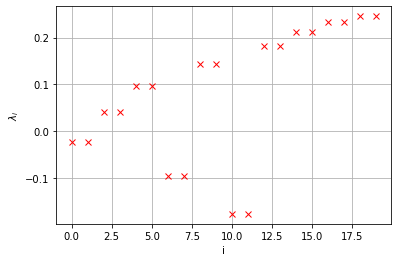

In [606]:
plt.plot(lam[:20], "rx")
plt.grid(True)
plt.xlabel("i")
plt.ylabel(r"$\lambda_i$");

## Two-level Bootstrap
We perform 4 bootstrap cycles, starting from 20 random test functions.
* R is constructed by SVD.
<!-- * P is contructed by regularized LS. -->
* P = R^T.
We measure the Residual to Error Ratio (RER) of test functions the two-level cycle convergence factor for $A x = 0$ (solving exactly at the coarse level), with $\nu_1+\nu_2=4$ relaxations per cycle 

In [661]:
# Fixed seed for reproducible results.
np.random.seed(0)

num_examples = 20
max_levels = 2
num_bootstrap_cycles = 4
threshold = 0.1
interpolation_method = "svd" # "ls"

# Initialize test functions (to random) and hierarchy at coarsest level.
level = hierarchy.create_finest_level(a)
multilevel = hm.hierarchy.multilevel.Multilevel(level)
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)

x_all = [None] * (num_bootstrap_cycles + 1)
i = 0
x_all[i] = x
logger.info("RER {:.2f}".format(norm(a.dot(x)) / norm(x)))
b = np.zeros_like(x)
x, conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x,num_sweeps=1000)
logger.info("Relax convergence factor {:.5f}".format(conv_factor))

# Relax vector + coarsen in first iteration; then 2-level cycle + improve hierarchy (bootstrap).
for i in range(1, num_bootstrap_cycles + 1):
    x, multilevel = hm.setup.auto_setup.bootstap(x, multilevel, max_levels, num_sweeps=30, threshold=threshold,
                                                interpolation_method=interpolation_method)
    x_all[i] = x
    logger.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))

    # Test two-level cycle convergence for A*x=0.
    conv_factor = []
    for nu in range(1, 4):
        two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 0).run(x)
        x0 = np.random.random((a.shape[0], ))
        y, c = hm.solve.run.run_iterative_method(multilevel.level[0].operator, two_level_cycle, x0, 30)
        conv_factor.append(c)
    logger.info("2-level conv factor {}".format(np.array(conv_factor)))

INFO     RER 2.91
INFO     Relax convergence factor 0.99957
INFO     Relax cycle conv factor 0.985
INFO     Coarsening level 0->1
INFO     Aggregate sizes [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
INFO     Level 1 size 48
INFO     RER 0.036
INFO     2-level conv factor [0.511 0.343 0.399]
INFO     Relax cycle conv factor 0.979
INFO     Coarsening level 0->1
INFO     Aggregate sizes [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
INFO     Level 1 size 48
INFO     RER 0.041
INFO     2-level conv factor [0.514 0.353 0.399]
INFO     Relax cycle conv factor 0.970
INFO     Coarsening level 0->1
INFO     Aggregate sizes [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
INFO     Level 1 size 48
INFO     RER 0.037
INFO     2-level conv factor [0.5   0.338 0.389]
INFO     Relax cycle conv factor 0.987
INFO     Coarsening level 0->1
INFO     Aggregate sizes [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
INFO     Level 1 size 48
INFO     RER 0.035
INFO     2-level conv factor [0.499 0

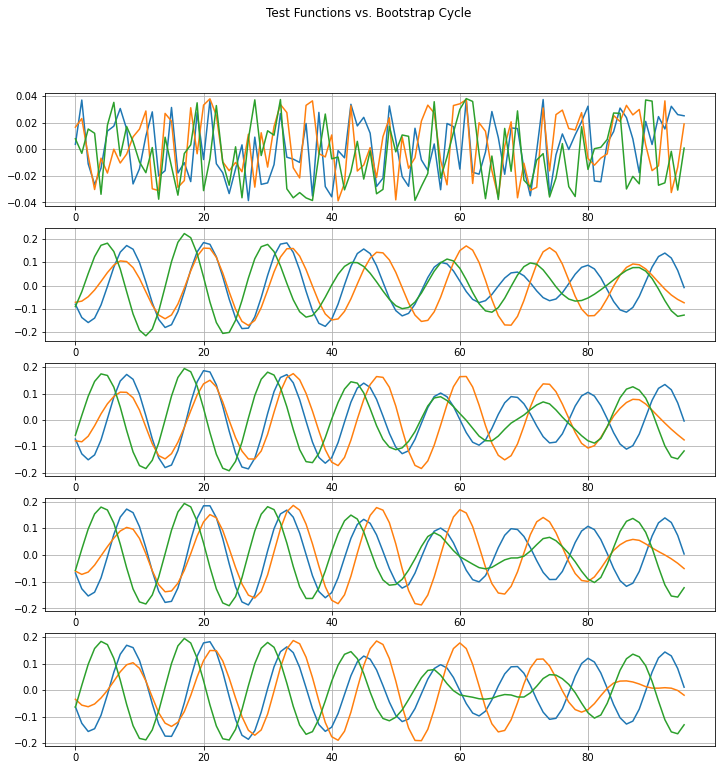

In [662]:
fig, axs = plt.subplots(len(x_all), 1, figsize=(12, 12))
fig.suptitle('Test Functions vs. Bootstrap Cycle')
for i, x in enumerate(x_all):
    ax = axs[i]
    for j in range(3):
        ax.plot(x[:, j])
    ax.grid(True);

Even though the test function RER decreases, the two-level convergence factor is excellent after one bootstrap cycle, then gets worse and does not improve.

## Two-level Cycle Properties

### Mock Cycle Predictions

In [626]:
level = multilevel.level[0]
num_relax_sweeps = np.arange(1, 6, dtype=int)
mock_conv_factor = np.zeros_like(num_relax_sweeps)
for i, nu in enumerate(num_relax_sweeps):
    relax_method = lambda x, b: level.relax(x, b)
    mock_cycle = hm.solve.mock_cycle.MockCycle(relax_method, r, nu)
    _, conv_factor = hm.solve.run.run_iterative_method(level.operator, mock_cycle,
                                                       hm.solve.run.random_test_matrix((n,), num_examples=1),
                                                       num_sweeps=10)
    print("{:2d} {:.3f}".format(nu, conv_factor))
#mock_conv_factor[i]

 1 0.575
 2 0.324
 3 0.192
 4 0.138
 5 0.139


### Fine vs. Coarse Operator Eigenvalues

In [627]:
lam = [None] * len(multilevel)
v = [None] * len(multilevel)
for l in range(len(multilevel)):
    level = multilevel.level[l]
    lam[l], v[l] = eig(level.a.todense(), b=level.b.todense())
    lam[l] = np.real(lam[l])
    ind = np.argsort(np.abs(lam[l]))
    lam[l] = lam[l][ind]
    v[l] = v[l][ind]

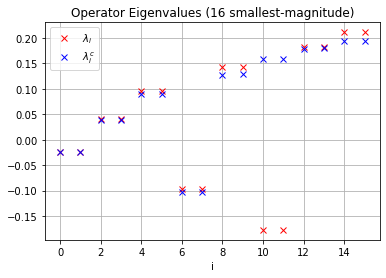

In [628]:
k = 16
lf = lam[0][:k][:, None] 
lc = lam[1][:k][:, None]

plt.plot(lf, 'rx', label="$\lambda_i$")
plt.plot(lc, 'bx', label="$\lambda_i^c$")
plt.xlabel("i")
plt.grid(True)
plt.title("Operator Eigenvalues ({} smallest-magnitude)".format(k));
plt.legend();
#plt.xlim([-0.3, 0.3]);
#plt.ylim([-0.1, 0.1]);

In [629]:
pd.DataFrame(np.concatenate((lf, lc, np.abs(lc - lf)/np.abs(lf)), axis=1),
            columns=("lam0", "lam1", "rel error"))

,lam0,lam1,rel error
0,-0.023932,-0.024386,0.018969
1,-0.023932,-0.024452,0.021701
2,0.040200,0.038923,0.031769
3,0.040200,0.039112,0.027084
4,0.095828,0.089120,0.069996
5,0.095828,0.089429,0.066776
6,-0.096528,-0.102917,0.066181
7,-0.096528,-0.103022,0.067269
8,0.142921,0.128138,0.103439
9,0.142921,0.128544,0.100598


The smallest $10$ eigenvalues are appoximated to $1%-10%$ error, but $\lambda_{10,11,14,15}$ arre badly approximated ($200%$ error, although looks like these pairs may be sign-flipped due to ordering eigenvalues by ascending absolute value, and might simply be swapped), so the two-level convergence is affected.

### Asymptotically Slowest Error in the Cycle
We consider a two-cycle with $(\nu=4, 0)$ relaxations and let $y$ be the slowest to converge error. That is, $y$ is the error after the Coarse-level correction (CLC). We compare $y$ and its CLC $P R y$.

In [630]:
# Fixed seed for reproducible results.
np.random.seed(0)

two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 4, 0, debug=True).run(x)
x0 = np.random.random((a.shape[0], ))
y, conv_factor = hm.solve.run.run_iterative_method(multilevel.level[0].operator, two_level_cycle, x0, 14,
                                                  print_frequency=1)
logger.info("2-level conv factor {:.2f}".format(conv_factor))

INFO     --------------------------------------------------------------------------------
INFO     Level    Operation          |R|           RER       
INFO     0        initial            9.0700e-01    1.6325e+00
INFO     0        relax 4            1.5574e-01    3.2256e-01
INFO     1        initial            1.9463e-01    2.8883e-01
INFO     1        coarsest           3.9147e-17    2.3165e-16
INFO     0        correction         2.0089e-01    1.4088e+00
INFO     --------------------------------------------------------------------------------
INFO     Level    Operation          |R|           RER       
INFO     0        initial            2.0089e-01    1.4088e+00
INFO     0        relax 4            5.7544e-02    5.3982e-01
INFO     1        initial            7.2788e-02    4.9586e-01
INFO     1        coarsest           1.0325e-17    2.0921e-16
INFO     0        correction         6.8197e-02    1.6042e+00
INFO     -------------------------------------------------------------------

In [631]:
# Interpolation operator.
coarse_level = multilevel.level[1]
p = coarse_level.p
r = coarse_level.r
print(p.shape)
print("P")
print(p.todense())

(96, 48)
P
[[ 0.411 -0.672  0.    ...  0.     0.     0.   ]
 [ 0.561 -0.253  0.    ...  0.     0.     0.   ]
 [ 0.57   0.228  0.    ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ...  0.    -0.607 -0.098]
 [ 0.     0.     0.    ...  0.    -0.347 -0.504]
 [ 0.     0.     0.    ...  0.     0.004 -0.795]]


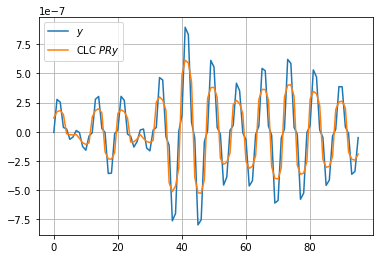

In [632]:
plt.plot(y, label="$y$")
correction = p.dot(r.dot(y))
plt.plot(correction, label="CLC $P R y$")
plt.legend()
plt.grid(True);

In [633]:
# ||P R y - y|| / ||y||
norm(p.dot(r.dot(y)) - y) / norm(y)

0.5465941951931105

In [634]:
i = np.argmax(correction)
print("argmax PRy = {}".format(i))
print("Interpolation coefficients of points {}..{}".format(i - 6, i + 6))
p[i - 6:i + 6, i // 2-4:i//2+4].todense()

argmax PRy = 41
Interpolation coefficients of points 35..47


matrix([[-0.47 ,  0.63 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   , -0.35 ,  0.71 ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   , -0.531,  0.304,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   , -0.585, -0.176,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   , -0.504, -0.61 ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.546,  0.578,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.599,  0.128,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.506, -0.352,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.295, -0.725,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.226, -0.76 ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.475, -0.388],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.607,  0.081]])

<!-- There are local interpolation errors. so how come the interpolation LS fitting process reports an excellent fit to smooth test vectors, yet there exists a $y$ for which it is bad? In this problem we know that fitting the AZMs should be good to obtain a good interpolation for all algebraically-smooth errors, so we don't need a bootstrap process that adds $y$ to the test function set. This seems more like a bug in the LS fitting. -->
Looks like we attain the mock cycle predictions for $\nu=1, 2$ only. But $R$' accuracy threshold is $10\%$#; so shouldn't we be getting a more accurate CLC and be able to sustain the mock cycle predictions for larger $\nu$?

In [636]:
# Test set relative interpolation error. 
x_test = x[:, 15:]
norm(x_test - p.dot(r.dot(x_test)), axis=1) / norm(x_test, axis=1)

array([0.017, 0.01 , 0.013, 0.021, 0.054, 0.034, 0.025, 0.021, 0.014, 0.011, 0.028, 0.067, 0.012, 0.003, 0.009, 0.01 , 0.012, 0.013, 0.024, 0.012, 0.007, 0.005, 0.01 , 0.024, 0.031, 0.007, 0.011, 0.011, 0.014, 0.014, 0.046, 0.026, 0.007, 0.003, 0.01 , 0.013, 0.031, 0.016, 0.019, 0.015, 0.008, 0.005, 0.015, 0.024, 0.017, 0.007, 0.014, 0.015, 0.019, 0.018, 0.023, 0.02 , 0.009, 0.004, 0.016, 0.02 , 0.017, 0.014, 0.01 , 0.01 , 0.014, 0.009, 0.021, 0.022, 0.011, 0.002, 0.018, 0.018, 0.032, 0.025,
       0.021, 0.025, 0.021, 0.012, 0.029, 0.034, 0.009, 0.007, 0.008, 0.007, 0.019, 0.014, 0.022, 0.021, 0.018, 0.01 , 0.022, 0.031, 0.038, 0.024, 0.016, 0.019, 0.029, 0.026, 0.052, 0.044])